## <p style="text-align: center;"> Intervertebral Disc Labeling With Learning Shape Information, A Look Once Approach </p>
####   <p style="text-align: center;">  R Azad, M Heidari, J Cohen-Adad, E Adeli, D Merhof </p>
####   <p style="text-align: center;">  RWTH Aachen, MILA lab, and Standford University </p>
####   <p style="text-align: center;">  MICCAI 2022 </p>

(-0.5, 1847.5, 583.5, -0.5)

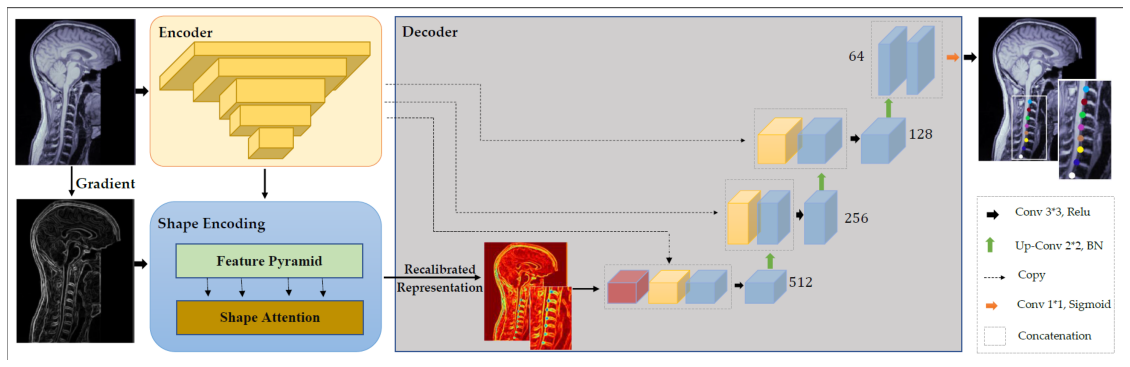

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np
img = Image.open( './images/mainmethod.png' )
img.load()
img = np.asarray( img, dtype="int32" )
fig = plt.figure(figsize = (20, 7))
plt.imshow(img)
plt.axis('off')

## Load the required libraries

In [1]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import argparse
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import torch.utils.data as data
from PIL import Image
import numpy as np
from torchvision.utils import save_image
import torch
import torch.nn.init as init
from model import ShapeUnet
import cv2
from functools import partial
from random import randint
import timeit
from matplotlib import pyplot as plt
from train_utils import *
from torch.utils.data import DataLoader 
import pickle
from jointsmseloss import JointsMSELoss
from utils_pose import *
import random
import torch.backends.cudnn as cudnn
import time
from progress.bar import Bar
import warnings
warnings.filterwarnings('ignore')


In [2]:
parser = argparse.ArgumentParser(description='Verterbal disc labeling using Shape Net')
## Parameters
parser.add_argument('--datapath', default='./prepared_data/prepared_trainset_t1', type=str,
                    help='Dataset address')                     
parser.add_argument('--njoints', default=11, type=int,
                    help='Number of joints')
parser.add_argument('--resume', default= False, type=bool,
                    help=' Resume the training from the last checkpoint')  
parser.add_argument('--epochs', default=120, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--modality', default='t1', type=str, metavar='N',
                    help='Data modality')
parser.add_argument('--train_batch', default=3, type=int, metavar='N', 
                    help='train batchsize')
parser.add_argument('--val_batch', default=4, type=int, metavar='N',
                    help='validation batchsize')
parser.add_argument('--solver', metavar='SOLVER', default='rms',
                    choices=['rms', 'adam'],
                    help='optimizers')
parser.add_argument('--lr', '--learning-rate', default=2.5e-4, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=0, type=float,
                    metavar='W', help='weight decay (default: 0)')
parser.add_argument('--schedule', type=int, nargs='+', default=[60, 90],
                    help='Decrease learning rate at these epochs.')
parser.add_argument('--gamma', type=float, default=0.1,
                    help='LR is multiplied by gamma on schedule.')
parser.add_argument('-e', '--evaluate', default=False, type=bool,
                    help='evaluate model on validation set')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--sigma-decay', type=float, default=0,
                    help='Sigma decay rate for each epoch.')
parser.add_argument('-f')
args = parser.parse_args()


In [3]:
def main(args):
    global best_acc
    global idx
    ## Load the prepared dataset
    with open(args.datapath, 'rb') as file_pi:
            full = pickle.load(file_pi)
    train_idx = int(np.round(len(full[0]) *0.9))
    validation_idx = int(np.round(len(full[0])))
    print(full[0].shape)
    full[0] = full[0][:, :, :, :, 0]
    
    ## Create a dataset loader
    full_dataset_train = image_Dataset(image_paths=full[0][0:train_idx], target_paths=full[1][:train_idx])
    full_dataset_val = image_Dataset(image_paths=full[0][train_idx:validation_idx],
                                        target_paths=full[1][train_idx:validation_idx], use_flip = False)

    MRI_train_loader = DataLoader(full_dataset_train, batch_size= args.train_batch,
                                shuffle=True,
                                num_workers=0)
    MRI_val_loader = DataLoader(full_dataset_val, batch_size=args.val_batch,
                            shuffle=False,
                            num_workers=0)
    
    # idx is the index of joints used to compute accuracy (we detect 11 joints starting from C1 to ...) 
    idx = [1,2,3,4,5,6,7,8,9,10,11]

    # create model
    print("==> creating model '{}'".format('UNet Model'))
    model = ShapeUnet(n_channels=1, n_classes=args.njoints)
    model = torch.nn.DataParallel(model).to(device)

    # define loss function (criterion) and optimizer
    criterion = JointsMSELoss().to(device)

    if args.solver == 'rms':
        optimizer = torch.optim.RMSprop(model.parameters(),
                                        lr=args.lr,
                                        momentum=args.momentum,
                                        weight_decay=args.weight_decay)
    elif args.solver == 'adam':
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=args.lr,
        )
    else:
        print('Unknown solver: {}'.format(args.solver))
        assert False
    
    # optionally resume from a checkpoint
    
    if args.resume:
       print("=> loading checkpoint to continue learing process")
       model.load_state_dict(torch.load(f'./weights/model_{args.modality}', map_location='cpu')['model_weights'])

    # evaluation only
    if args.evaluate:
        print('\nEvaluation only')
        print('loading the pretrained weight')
        model.load_state_dict(torch.load(f'./weights/model_{args.modality}', map_location='cpu')['model_weights'])
        return
    
    # train and eval
    lr = args.lr
    for epoch in range(args.start_epoch, args.epochs):
        lr = adjust_learning_rate(optimizer, epoch, lr, args.schedule, args.gamma)
#         print('\nEpoch: %d | LR: %.8f' % (epoch + 1, lr))

        # decay sigma
        if args.sigma_decay > 0:
            MRI_train_loader.dataset.sigma *=  args.sigma_decay
            MRI_val_loader.dataset.sigma *=  args.sigma_decay

        # train for one epoch
        train_loss, train_acc = train(MRI_train_loader, model, criterion, optimizer)

        # evaluate on validation set
        valid_loss, valid_acc  = validate(MRI_val_loader, model, criterion)

        # remember best acc and save checkpoint
        if valid_acc > best_acc:
           state = copy.deepcopy({'model_weights': model.state_dict()})
           torch.save(state, f'./weights/model_{args.modality}')
           best_acc = valid_acc
                

def train(train_loader, model, criterion, optimizer):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acces = AverageMeter()
    loss_dices = AverageMeter()
    # switch to train mode
    model.train()

    end = time.time()

    
    bar = Bar('Train', max=len(train_loader))
    
    for i, (input, target, vis, gx) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        input, target, gx = input.to(device), target.to(device, non_blocking=True), gx.to(device)
        vis = vis.to(device, non_blocking=True)
        # compute output
        output = model(input, gx) 
        loss = criterion(output, target, vis)
        acc = accuracy(output, target, idx)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))
        acces.update(acc[0], input.size(0))
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.6f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | Acc: {acc: .4f}'.format(
                    batch=i + 1,
                    size=len(train_loader),
                    data=data_time.val,
                    bt=batch_time.val,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg*100,
                    acc=acces.avg
                    )
        bar.next()
    print(f'Epoch: {ep} Train Loss >> {losses.avg*100} and accuracy is>> {acces.avg}')
    return losses.avg, acces.avg


ep = 0
def validate(val_loader, model, criterion):
    global ep
    Flag_visualize = True
    ep += 1
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acces = AverageMeter()
    loss_dices = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar('Eval ', max=len(val_loader))
    with torch.no_grad():
        for i, (input, target, vis, gx) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input, target, gx = input.to(device), target.to(device, non_blocking=True), gx.to(device)
            vis = vis.to(device, non_blocking=True)
            # compute output
            output = model(input, gx)
            loss = criterion(output, target, vis)

            acc = accuracy(output.cpu(), target.cpu(), idx)
            loss_dice = dice_loss(output, target)

            if Flag_visualize:
                # save the visualization only for the first batch of the validation
                save_epoch_res_as_image2(input, output, target, epoch_num=ep, target_th=0.5)
                Flag_visualize = False

            # measure accuracy and record loss
            losses.update(loss.item(), input.size(0))
            acces.update(acc[0], input.size(0))
            loss_dices.update(loss_dice.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.6f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | Acc: {acc: .4f}| dice: {dice:.4f}'.format(
                        batch=i + 1,
                        size=len(val_loader),
                        data=data_time.val,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg*100,
                        acc=acces.avg,
                        dice=loss_dices.avg*100
                        )
            bar.next()
        print(f'Epoch: {ep} Validation Loss >> {losses.avg*100} and accuracy is>> {acces.avg}')
        bar.finish()
    return losses.avg, acces.avg

In [4]:
seed = 68
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

# init global variables
best_acc = 0
idx = []

# select proper device to run
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True 
main(args)

(212, 320, 320, 1, 1)
==> creating model 'UNet Model'
Epoch: 0 Train Loss >> 3.99661512450554 and accuracy is>> 0.0011304140789434314
Epoch: 1 Validation Loss >> 2.22234320605085 and accuracy is>> 0.0
Epoch: 1 Train Loss >> 1.6080219069427533 and accuracy is>> 0.0019854491110891104
Epoch: 2 Validation Loss >> 1.0953206435910292 and accuracy is>> 0.0357142873108387
Epoch: 2 Train Loss >> 0.8881000604441497 and accuracy is>> 0.0034758583642542362
Epoch: 3 Validation Loss >> 0.607291329652071 and accuracy is>> 0.0
Epoch: 3 Train Loss >> 0.5394417657248715 and accuracy is>> 0.000581733591388911
Epoch: 4 Validation Loss >> 0.3809534678501742 and accuracy is>> 0.0
Epoch: 4 Train Loss >> 0.34258741158894535 and accuracy is>> 0.0021758347284048796
Epoch: 5 Validation Loss >> 0.23555125531163953 and accuracy is>> 0.0
Epoch: 5 Train Loss >> 0.22559862154784624 and accuracy is>> 0.0011304140789434314
Epoch: 6 Validation Loss >> 0.15999191451729053 and accuracy is>> 0.0
Epoch: 6 Train Loss >> 0.15

## Sample prediction resutls (last epoch)

Text(0.5, 1.0, 'Prediction Resutls, top row GT, bottom row the prediction')

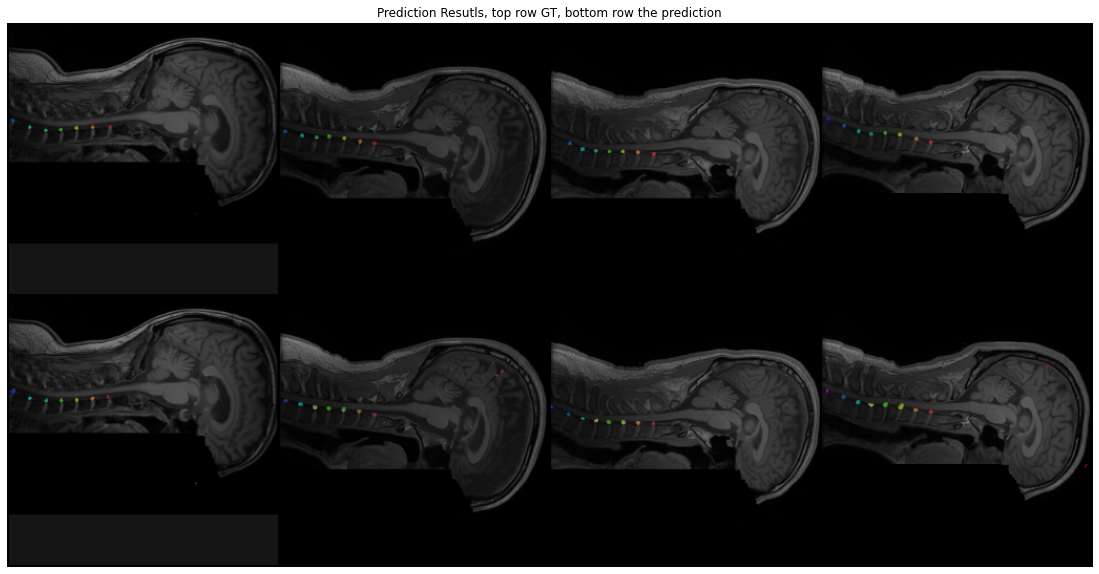

In [49]:
img = Image.open('./visualize/epoch_0120_res2.png')
img.load()
img = np.asarray( img, dtype="int32" )
fig = plt.figure(figsize = (20, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Prediction Resutls, top row GT, bottom row the prediction')


In [ ]:
@article{azad2022intervertebral,
  title={Intervertebral Disc Labeling With Learning Shape Information, A Look Once Approach},
  author={Azad, Reza and Heidari, Moein and Cohen-Adad, Julien and Adeli, Ehsan and Merhof, Dorit},
  journal={arXiv preprint arXiv:2204.02943},
  year={2022}
}